In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir('../')

In [3]:
import sys
sys.path.append('/home/njr61/rds/hpc-work/spurious-concepts/ConceptBottleneck')

In [4]:
import torch
from sklearn.metrics import roc_auc_score
from sklearn.neural_network import MLPClassifier
import torch.nn as nn
import torch.optim as optim
import pickle
import matplotlib.pyplot as plt
import torch.nn.functional as F
from PIL import Image
from captum.attr import visualization as viz
from matplotlib.colors import LinearSegmentedColormap
import cv2
from copy import copy 
import itertools

In [5]:
from ConceptBottleneck.CUB.models import ModelXtoC, ModelOracleCtoY
from ConceptBottleneck.CUB.dataset import load_data

In [6]:
from src.images import *
from src.util import *
from src.models import *
from src.plot import *

## Set up dataset + model

In [58]:
num_objects = 2
noisy=False
weight_decay = 0.0004
encoder_model='small7'

In [59]:
def get_log_folder(dataset,weight_decay,encoder_model):
    if weight_decay == 0.0004 and encoder_model == 'inceptionv3':
        log_folder = f"results/{dataset}/joint/joint"
    elif weight_decay == 0.0004:
        log_folder = f"results/{dataset}/joint_model_{encoder_model}/joint"
    elif encoder_model == 'inceptionv3':
        log_folder = f"results/{dataset}/joint_wd_{weight_decay}/joint"
    else:
        log_folder = f"results/{dataset}/joint_model_{encoder_model}_wd_{weight_decay}/joint"
    return log_folder

In [60]:
dataset_name = "synthetic_{}".format(num_objects)
if noisy:
    dataset_name += "_noisy"

data_dir = "../cem/cem/{}/preprocessed/".format(dataset_name)
data_dir

'../cem/cem/synthetic_2/preprocessed/'

In [61]:
if num_objects == 2:
    concept_combinations = [
        [1,0,1,0],
        [0,1,0,1],
        [1,0,0,1],
        [0,1,1,0],
    ]
    concept_y = [
        0,1,1,1
    ]
else:
    concept_combinations = []
    concept_y = []
    for i in range(128):
        is_triangle = [random.randint(0,1) for j in range(num_objects)]
        is_square = [1-j for j in is_triangle]
        
        attribute_label = [elem for pair in zip(is_triangle, is_square) for elem in pair]
        concept_combinations.append(attribute_label)
        
        task_y = int(sum(is_square)<num_objects//2)
        concept_y.append(task_y)

In [62]:
train_data_path = os.path.join(data_dir, 'train.pkl')
val_data_path = train_data_path.replace('train.pkl', 'val.pkl')
extra_data_path = train_data_path.replace('train.pkl','extra.pkl')

In [63]:
pretrained = True
freeze = False
use_aux = True
expand_dim = 0
three_class = False
use_attr = True
no_img = False
batch_size = 64
uncertain_labels = False
image_dir = 'images'
num_class_attr = 2
resampling = False

In [64]:
train_loader = load_data([train_data_path], use_attr, no_img, batch_size, uncertain_labels, image_dir=image_dir, 
                         n_class_attr=num_class_attr, resampling=resampling, path_transform=lambda path: "../cem/cem/"+path, is_training=False)
val_loader = load_data([val_data_path], use_attr, no_img=False, batch_size=64, image_dir=image_dir, n_class_attr=num_class_attr, path_transform=lambda path: "../cem/cem/"+path)
if os.path.exists(extra_data_path):
    extra_loader = load_data([extra_data_path], use_attr, no_img=False, batch_size=64, image_dir=image_dir, n_class_attr=num_class_attr, path_transform=lambda path: "../cem/cem/"+path)

In [65]:
log_folder = get_log_folder(dataset_name,weight_decay,encoder_model)
joint_location = "ConceptBottleneck/{}/best_model_42.pth".format(log_folder)
print(joint_location)
joint_model = torch.load(joint_location,map_location=torch.device('cpu'))
r = joint_model.eval()

ConceptBottleneck/results/synthetic_2/joint_model_small7/joint/best_model_42.pth


## Plot the Dataset

In [33]:
train_pkl = pickle.load(open(train_data_path,"rb"))
val_pkl = pickle.load(open(val_data_path,"rb"))
if os.path.exists(extra_data_path):
    extra_pkl = pickle.load(open(extra_data_path,"rb"))

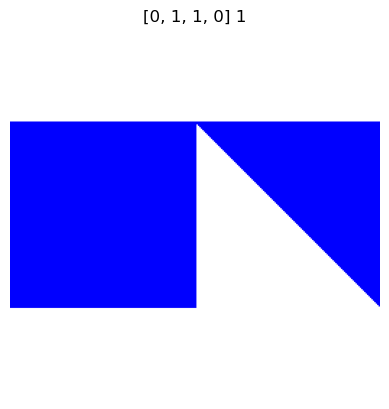

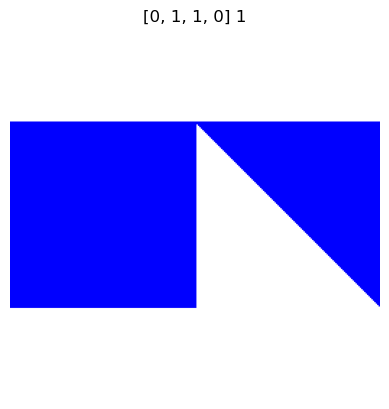

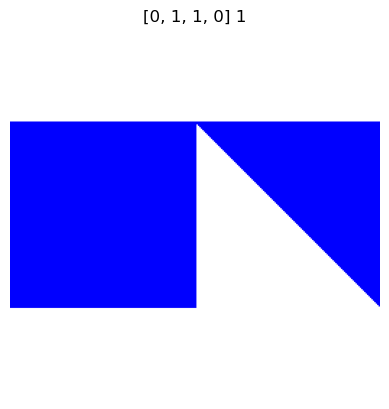

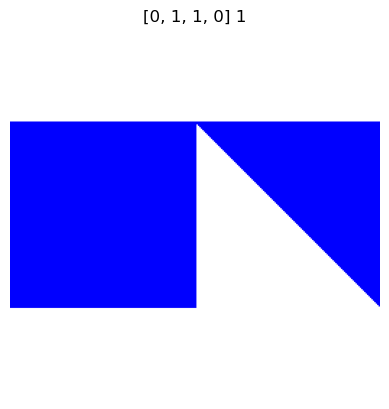

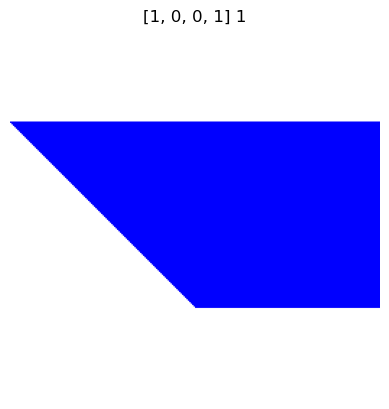

In [34]:
num_images_show = 5
for i in range(num_images_show):
    img_path = '../cem/cem/'+train_pkl[i]['img_path']
    image = Image.open(img_path)
    image_array = np.array(image)
    plt.figure()
    plt.imshow(image_array)
    plt.axis('off') 
    plt.title(str(train_pkl[i]['attribute_label']) + ' '+str(train_pkl[i]['class_label']))

## Analyze Accuracy

In [35]:
get_accuracy(joint_model,run_joint_model,train_loader), get_accuracy(joint_model,run_joint_model,val_loader)

(tensor(1.), tensor(1.))

In [36]:
get_concept_accuracy(joint_model,run_joint_model,train_loader,sigmoid=True)

(1.7365811540485878e-41, 1.0)

In [37]:
get_concept_accuracy_by_concept(joint_model,run_joint_model,train_loader,sigmoid=True)

tensor([1., 1., 1., 1.])

## Analyze Concept-Task Relationships

In [38]:
val_images = []
val_y = []
val_c = []
for batch in val_loader:
    x, y, c = batch  
    val_images.append(x)
    val_y.append(y)
    val_c.append(torch.stack(c).T)
val_images = torch.cat(val_images, dim=0)
val_y = torch.cat(val_y,dim=0)
val_c = torch.cat(val_c,dim=0)

In [39]:
if os.path.exists(extra_data_path):
    extra_images = []
    extra_y = []
    extra_c = []
    for batch in extra_loader:
        x,y,c = batch
        extra_images.append(x)
        extra_y.append(y)
        extra_c.append(torch.stack(c).T)
    extra_images = torch.cat(extra_images, dim=0)
    extra_y = torch.cat(extra_y,dim=0)
    extra_c = torch.cat(extra_c,dim=0)

In [120]:
attribute_weights, y_pred, c_pred = get_attribute_class_weights(
    joint_model,run_joint_model,joint_model.sec_model.linear.weight,val_images)

In [121]:
attributes = [str(i) for i in range(num_objects*2)]

In [122]:
attribute_weights[:2,:,0]

tensor([[-308.4182, -519.3881],
        [ 247.7104,  877.4724]], grad_fn=<SelectBackward0>)

[-7.323101997375488, -198.94480895996094] ['0 (#0)', '1 (#1)']


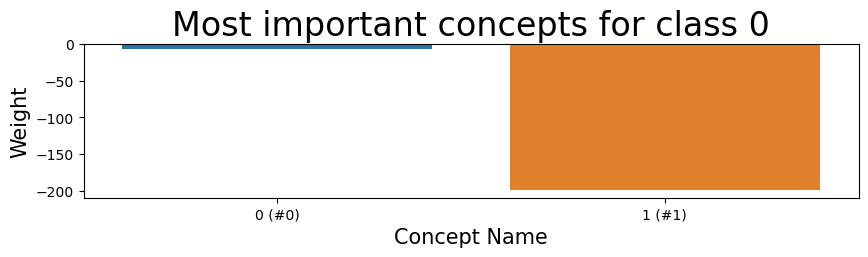

In [123]:
plt.figure(figsize=(10,2))
plt.title("Most important concepts for class 0",fontsize=24)
plt.xlabel("Concept Name",fontsize=15)
plt.ylabel("Weight",fontsize=15)
plot_most_important_classes(attribute_weights,attributes,0)

[336.104248046875, 5.881654262542725] ['1 (#1)', '0 (#0)']


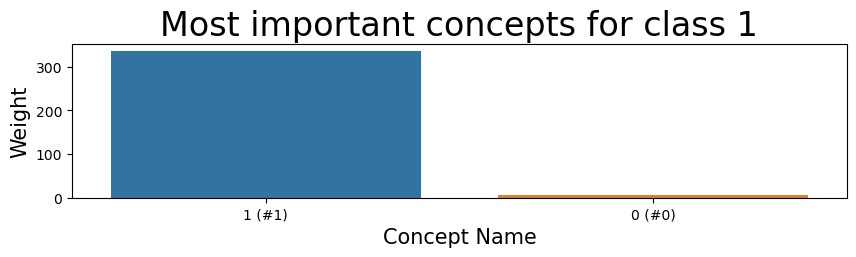

In [124]:
plt.figure(figsize=(10,2))
plt.title("Most important concepts for class 1",fontsize=24)
plt.xlabel("Concept Name",fontsize=15)
plt.ylabel("Weight",fontsize=15)
plot_most_important_classes(attribute_weights,attributes,1)

In [125]:
y_pred == joint_model.sec_model.forward(torch.nn.Sigmoid()(c_pred.T))

tensor([[True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [T

### Impact of Each concept combination on task

In [126]:
for concept_combo, true_class in zip(concept_combinations,concept_y):
    predicted_result = joint_model.sec_model.forward(torch.Tensor([concept_combo]))
    predicted_class = torch.argmax(predicted_result[0])
    print("Predicted class {}, true class {}".format(predicted_class,true_class))

Predicted class 0, true class 0
Predicted class 1, true class 0
Predicted class 1, true class 0
Predicted class 0, true class 0
Predicted class 1, true class 0
Predicted class 1, true class 0
Predicted class 0, true class 0
Predicted class 1, true class 0
Predicted class 1, true class 0
Predicted class 0, true class 0
Predicted class 0, true class 0
Predicted class 0, true class 0
Predicted class 0, true class 0
Predicted class 0, true class 0
Predicted class 0, true class 0
Predicted class 1, true class 0
Predicted class 1, true class 0
Predicted class 0, true class 0
Predicted class 1, true class 0
Predicted class 1, true class 0
Predicted class 1, true class 0
Predicted class 1, true class 0
Predicted class 1, true class 0
Predicted class 1, true class 0
Predicted class 1, true class 0
Predicted class 1, true class 0
Predicted class 0, true class 0
Predicted class 1, true class 0
Predicted class 1, true class 0
Predicted class 0, true class 0
Predicted class 1, true class 0
Predicte

In [127]:
num_concepts = len(concept_combinations[0])
baseline_concepts = [0 for i in range(num_concepts)]

for i in range(num_concepts):
    new_concepts = copy(baseline_concepts)
    new_concepts[i] = 1
    predicted_result = joint_model.sec_model.forward(torch.Tensor([new_concepts]))
    predicted_class = torch.argmax(predicted_result[0])
    print("Predicted class {}, when setting concept {} to 1".format(predicted_class,i))

Predicted class 1, when setting concept 0 to 1
Predicted class 0, when setting concept 1 to 1


## Impact of Each Image on the Task

In [128]:
for i in range(num_concepts):
    avg_impact = np.array([0.0 for i in range(num_concepts)])
    num_combos = 0
    
    for concept_combo in concept_combinations:
        if concept_combo[i] != 0:
            continue

        closest_combo = None
        
        for other_combo in concept_combinations:
            if other_combo[i] != 1:
                continue

            if closest_combo == None:
                closest_combo = other_combo

            current_norm = np.linalg.norm(np.array(closest_combo)-np.array(concept_combo))
            this_norm = np.linalg.norm(np.array(other_combo)-np.array(concept_combo))
                
            if this_norm < current_norm:
                closest_combo = other_combo
                
        img_regular = [i for i in range(len(val_pkl)) if val_pkl[i]['attribute_label'] == concept_combo]
        img_regular = np.random.choice(img_regular)
        
        img_other = [i for i in range(len(val_pkl)) if val_pkl[i]['attribute_label'] == closest_combo]
        img_other = np.random.choice(img_other)
        
        y,c = run_joint_model(joint_model,val_images[img_regular:img_regular+1])
        y_other,c_other = run_joint_model(joint_model,val_images[img_other:img_other+1])
        
        c = torch.nn.Sigmoid()(c).detach().numpy().T[0]
        c_other = torch.nn.Sigmoid()(c_other).detach().numpy().T[0]
        
        num_combos += 1
        
        avg_impact += (c_other-c)
        
    avg_impact /= num_combos
    print("Concept {} Impact: {}".format(i,avg_impact))
        

Concept 0 Impact: [ 1. -1.]
Concept 1 Impact: [-1.  1.]


In [129]:
if os.path.exists(extra_data_path):
    for i in range(len(extra_images)):
        concepts = extra_c[i]
        y,c = run_joint_model(joint_model,extra_images[i:i+1])
        c = c.T

        y = y.detach().numpy()
        c =  torch.nn.Sigmoid()(c).detach().numpy()
        concepts = concepts.detach().numpy()
        c = np.round(c,2)

        print("For concepts {}, predicted y {}, c {}".format(concepts,y[0],c[0]))

## Analyze Concept-Input Relationships

### Counterfactual Images

#### Blank, Filled, and Half Images

In [130]:
no_color = torch.Tensor([0.25,0.25,0.25])
full_color = torch.Tensor([-0.25,-0.25,0.25])

In [131]:
blank_image = no_color.clone().view(3, 1, 1).expand((3,256,256))
full_image = full_color.clone().view(3, 1, 1).expand_as(blank_image)

half_left = no_color.view(3, 1, 1).expand_as(blank_image).clone()
half_left[:,:,:128] = full_image[:,:,:128]

half_right = no_color.clone().view(3, 1, 1).expand_as(blank_image).clone()
half_right[:,:,128:] = full_image[:,:,128:]

In [132]:
all_images = [blank_image,full_image,half_left,half_right]
all_images = torch.stack(all_images)
str_names = ["Blank","Full","Half-Left","Half-Right"]

In [133]:
y,c = run_joint_model(joint_model,all_images)
c = c.T
c = torch.nn.Sigmoid()(c).detach().numpy()
c = np.round(c,3)

In [134]:
for i in range(len(str_names)):
    print("For image {}, concepts {}".format(str_names[i],c[i]))

For image Blank, concepts [1. 0.]
For image Full, concepts [0. 1.]
For image Half-Left, concepts [0. 1.]
For image Half-Right, concepts [1. 0.]


### Maximal Activation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1.0


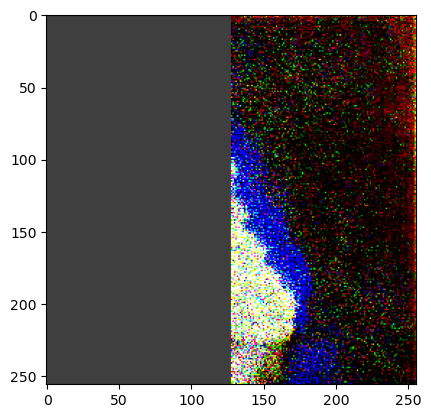

In [66]:
ret_image = get_maximal_activation(joint_model,run_joint_model,0,valid_left_image)
activation_0 = torch.nn.Sigmoid()(run_joint_model(joint_model,ret_image)[1])[0][0].detach().numpy()
print(activation_0)
plt.imshow(ret_image.detach()[0].numpy().transpose((1,2,0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(1., grad_fn=<SelectBackward0>)


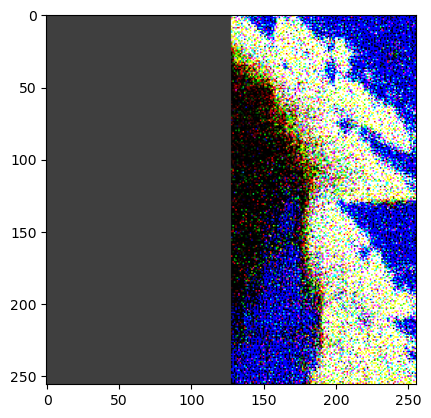

In [67]:
ret_image = get_maximal_activation(joint_model,run_joint_model,1,valid_left_image)
activation_1 = torch.nn.Sigmoid()(run_joint_model(joint_model,ret_image)[1])[1][0]
print(activation_1)
plt.imshow(ret_image.detach()[0].numpy().transpose((1,2,0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


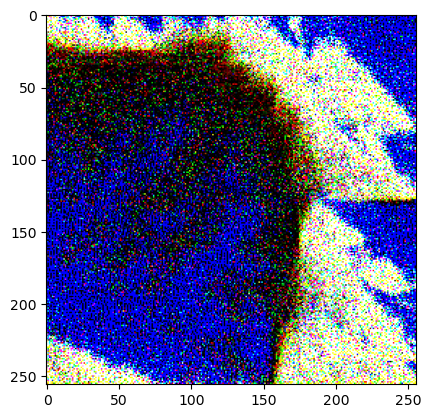

In [68]:
ret_image = get_maximal_activation(joint_model,run_joint_model,1,lambda img: img)
plt.imshow(ret_image.detach()[0].numpy().transpose((1,2,0)))

tensor(1., grad_fn=<SelectBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(1., grad_fn=<SelectBackward0>)


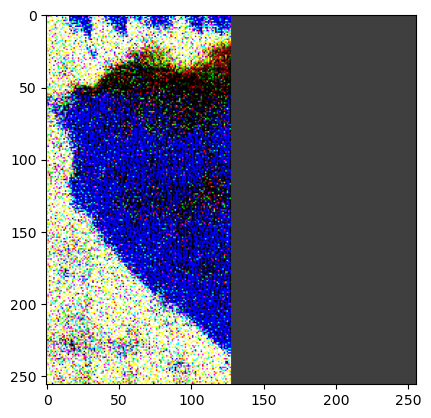

In [69]:
if num_objects > 1:
    ret_image = get_maximal_activation(joint_model,run_joint_model,2,valid_right_image)
    activation_2 = torch.nn.Sigmoid()(run_joint_model(joint_model,ret_image)[1])[2][0]
    print(activation_2)

    ret_image = get_maximal_activation(joint_model,run_joint_model,3,valid_right_image)
    activation_3 = torch.nn.Sigmoid()(run_joint_model(joint_model,ret_image)[1])[3][0]
    print(activation_3)
    plt.imshow(ret_image.detach()[0].numpy().transpose((1,2,0)))

In [70]:
if activation_0 > 0.9 and activation_1 > 0.9:
    if num_objects > 1:
        if activation_2 > 0.9 and activation_3 > 0.9:
            print("Able to create adversarial images")
        else:
            print("Unable to create adversarial images")
    else:
        print("Able to create adversarial images")
else:
    print("Unable to create adversarial images")

Able to create adversarial images


### Patch-Based

In [51]:
grid_size = 3
grid_width = 256//grid_size
combinations = list(itertools.product([0, 1], repeat=grid_size**2))
combinations_grid = [[list(combination[i:i+grid_size]) for i in range(0, grid_size**2, grid_size)] for combination in combinations]


In [52]:
def combo_to_image(combo):
    default_image = no_color.clone().view(3, 1, 1).expand((3,256,256)).clone()
    
    for i in range(grid_size):
        for j in range(grid_size):
            if combo[i][j] == 1:
                color_tensor = full_color.view(3, 1, 1).expand((3, grid_width, grid_width))
                default_image[:,i*grid_width:(i+1)*grid_width,j*grid_width:
                              (j+1)*grid_width] = color_tensor
                
                
    return default_image

In [53]:
all_images = torch.stack([combo_to_image(i) for i in combinations_grid])

In [54]:
y,c = run_joint_model(joint_model,all_images)
c = torch.nn.Sigmoid()(c)
c = c.T

In [55]:
def combination_to_string(combination):
    return ''.join(str(element) for row in combination for element in row)

In [56]:
combination_to_score = {}
for i,combination in enumerate(combinations_grid):
    condensed_string = combination_to_string(combination)
    combination_to_score[condensed_string] = c.detach().numpy()[i,0]

In [57]:
largest_indices = np.argsort(c.detach().numpy()[:,0])[-25:]

In [58]:
max_dif = 0
max_ind = -1

for i in largest_indices:
    combo_original = combinations_grid[i]
    modified_combo = deepcopy(combo_original)
    for j in range(grid_size):
        modified_combo[j][-1] = 0
        
    score_original = combination_to_score[combination_to_string(combo_original)]
    score_modified = combination_to_score[combination_to_string(modified_combo)]

    if score_original-score_modified > max_dif:
        max_dif = score_original-score_modified
        max_ind = i

In [59]:
combo_original = combinations_grid[max_ind]
modified_combo = deepcopy(combo_original)
for j in range(grid_size):
    modified_combo[j][-1] = 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


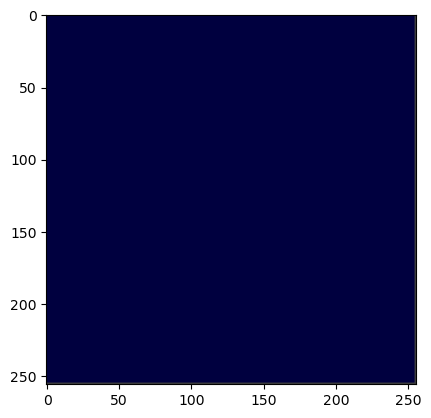

In [60]:
plt.imshow(combo_to_image(combo_original).detach().numpy().transpose((1,2,0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


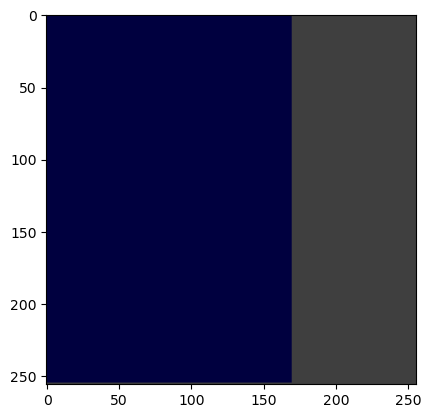

In [61]:
plt.imshow(combo_to_image(modified_combo).detach().numpy().transpose((1,2,0)))

In [62]:
if combination_to_score[combination_to_string(combo_original)] > 0.8 and combination_to_score[combination_to_string(modified_combo)] < 0.2:
    print("Using right-hand side significantly impacts concept activation")
else:
    print("Inconclusive results from patch-based experiments")
combination_to_score[combination_to_string(combo_original)], combination_to_score[combination_to_string(modified_combo)]

Inconclusive results from patch-based experiments


(1.8251794e-35, 0.0)

### Saliency Maps

In [ ]:
if combination_to_score[combination_to_string(combo_original)] > 0.8 and combination_to_score[combination_to_string(modified_combo)] < 0.2:
    print("Using right-hand side significantly impacts concept activation")
else:
    print("Inconclusive results from patch-based experiments")

if activation_0 > 0.9 and activation_1 > 0.9:
    print("Able to create adversarial images")
else:
    print("Unable to create adversarial images")


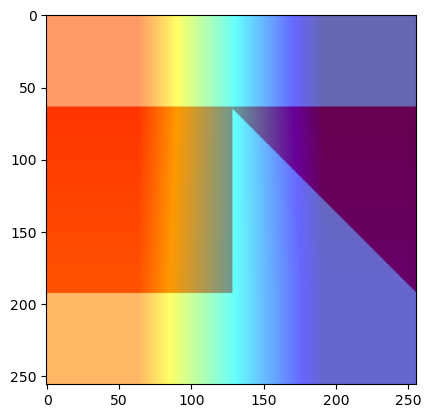

In [71]:
plot_gradcam(joint_model,run_joint_model,0,val_images,0,val_pkl)

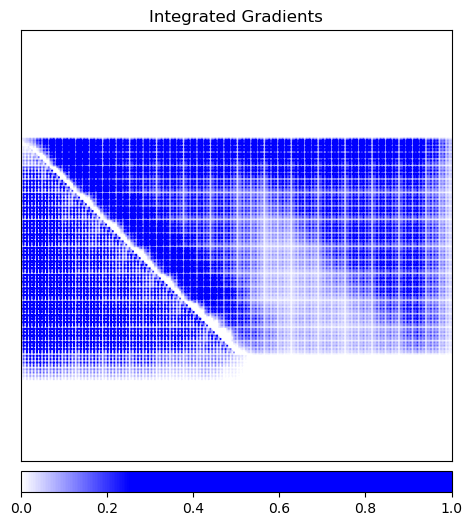

In [23]:
plot_integrated_gradients(joint_model,run_joint_model,0,val_images,0)

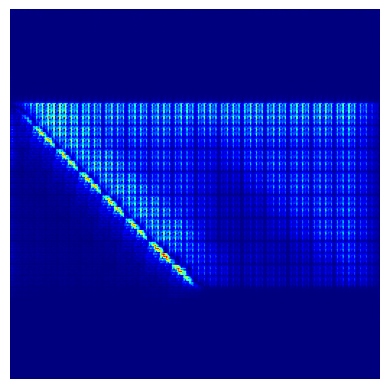

In [24]:
plot_saliency(joint_model,run_joint_model,0,val_images,0)